In [1]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
N = 1000; Ne = int( 0.8*N ); Ni = int( 0.2*N );

T = 1;      # total time we want to simulate, 1 s
dt = 0.001; # 1 ms temporal resolution

time = np.linspace(dt,T, int(T/dt)) # time in s

# decide which 20% neurons are inhibitory
inhibitory_indx = np.sort(np.random.choice(range(N),Ni,replace=False))
inhibitory_indx   # the indices of inhibitory neurons

array([  3,   9,  12,  26,  29,  38,  39,  46,  47,  50,  51,  61,  62,
        78,  94, 102, 107, 115, 116, 126, 132, 140, 149, 150, 152, 158,
       160, 161, 162, 164, 166, 169, 173, 181, 182, 185, 188, 189, 199,
       211, 213, 221, 224, 225, 230, 231, 232, 242, 249, 258, 259, 261,
       268, 273, 286, 289, 290, 297, 302, 304, 305, 311, 319, 327, 330,
       333, 336, 338, 340, 342, 343, 344, 350, 352, 359, 361, 363, 368,
       377, 383, 391, 399, 401, 413, 415, 416, 421, 423, 424, 435, 438,
       441, 444, 448, 453, 462, 485, 486, 487, 489, 490, 492, 494, 496,
       498, 503, 504, 513, 518, 523, 526, 528, 531, 532, 537, 541, 546,
       555, 567, 570, 578, 586, 588, 592, 593, 601, 603, 612, 631, 632,
       633, 635, 643, 644, 650, 653, 661, 667, 679, 686, 687, 693, 694,
       696, 697, 700, 707, 708, 709, 715, 720, 726, 728, 731, 743, 744,
       749, 751, 753, 769, 772, 779, 781, 787, 793, 799, 801, 807, 808,
       811, 817, 823, 828, 844, 855, 858, 859, 869, 870, 881, 88

In [3]:
J0 = 0.3; J1 = 0.015; J2 = 0.02; l = 0.15
sigma =100      # adjusting synaptic weights 

x0 =  time/3    # rats moving with a constant speed
I0 = 1.02       # baseline excitation for the neurons
lambda_e = 0.03 # degree of the space-specific input modulation
lambda_i = 0.02 # strength of the oscillatory component
Vres = 0.85     # reset potential
theta = 1       # spike threshold

# 1-d array, storing the position of each neuron
positions = np.linspace(0,1,N,endpoint=True)
positions[inhibitory_indx]=10

# pre-define Jij_ex
Jij_ex = np.zeros([N, N])

In [4]:
# reliability of synaptic transmission, equal to 1 with prob. 0.2
def s_ex():
    rand = np.random.uniform(0,1,1)
    if rand<0.2:
        return 1
    else:
        return 0

# reliability of synaptic transmission, equal to 1 with prob. 0.7 
def s_in():
    rand = np.random.uniform(0,1,1)
    if rand<0.7:
        return 1
    else:
        return 0

# Equ. 8, asymmetry of the synaptic contacts
# synaptic strengths in the direction of motion are stronger than those in the opposite direction
# sigma > 1
def sigma_ij_comp(i,j,sigma):
    if i<j:
        result =1
    else:
        result = sigma
    return result

# Equ. 7, characterizing the weight of synaptic interactions between the pyramidal neurons
# positions[i] - the position of the rat in the linear apparatus where the neuron
# receives the strongest external excitation while the rat moves in a specific direction
def Jij_ex_comp(i, j):
    sigma_ij = sigma_ij_comp(i,j,sigma)
    result = sigma_ij * J1 * np.exp(-np.abs(positions[i]-positions[j])/l)
    return result

def Jij_in_comp(i, j):
    sigma_ij = sigma_ij_comp(i,j,sigma)
    result = sigma_ij * J2 * np.exp(-np.abs(positions[i]-positions[j])/l)
    return result

In [5]:
# compute each element of Jij_ex, treat Jij_ex as a constant matrix
for ii in range(N):
    for jj in range(N):
        Jij_ex[ii,jj] = Jij_ex_comp(ii,jj)
    

Jij_in=np.ones([1000,1000]) *0.6  

# I_ex - external currents arising from inputs outside the network
# Equ. 9, external inputs for excitatory pyramidal cells
# assume the input deriving preferentially from entorhinal cortex,
# representing a preprocessed sensory input, carrying info about 
# the rat's location in the apparatus
I_ext_ex = np.zeros([Ne, len(time)])


for i in range(Ne):
    for t in range(len(time)):
        I_ext_ex[i,t] = I0 * (1 + lambda_e*np.exp(-np.abs(positions[i]-x0[t])/l))
I_ext_ex=np.interp(I_ext_ex, (I_ext_ex.min(), I_ext_ex.max()), (0.99999, 1.006))  


# Equ. 10, inhibitory external inputs
# e.g. inhibitory GABAergic input from the medial septum, which preferentially
# targets inhibitory interneurons
I_ext_in = np.zeros(len(time))

# inhibitory GABAergic input from the medial septum is modulated at a frequency of
# 6-9 Hz, included in the model as an oscillatory input to the inhibitory population
for t in range(len(time)):
    I_ext_in[t] = I0 * (1 + lambda_i * np.cos(2*np.pi*time[t]*8)) # 6-9 Hz

I_ext_in


# I_ext = combine I_ext_ex and I_ext_in
I_ext = np.zeros([N, len(time)])
cnt_ex = 0
cnt_in = 0
for i in range(N):
    if i in inhibitory_indx:
        I_ext[i,:] = I_ext_in
        cnt_in = cnt_in + 1
    else:
        I_ext[i,:] = I_ext_ex[cnt_ex,:]
        cnt_ex = cnt_ex + 1
        


# compute I_ex and I_in
I_ex = np.zeros([N, len(time)])
I_in = np.zeros([N, len(time)])

t_spike = np.zeros([N, len(time)])

Is = I_ex - I_in  # total synaptic currents from intrinsic inputs

V = np.zeros([N, len(time)])
V[:,0] = Vres


# when a spike arrives at a presynaptic terminal, the postsynaptic current is
# instantaneously increased according to the strength of the synapse, and decay
# with a time constant tau_ex (tau_in)
tau_ex = 6/1000   # tau_ex, decay constant for excitatory synapses
tau_in = 4/1000   # tau_in, decay constant for inhibitory synapses
tau = 20/1000     # membrane time constant


# Equ. 3, characterizing how membrane potential of neurons evolve
# Euler's method to solve the differential equation
def integrate_and_fire(V, t_spike_time, t, Is):
    for i in range(N):   
        I_in[i,t] = I_in[i,t-1] + dt*(-I_in[i,t-1]/tau_in + s_in()*np.dot(Jij_in[i,:],t_spike_time[:,t-1]))
        I_ex[i,t] = I_ex[i,t-1] + dt*(-I_ex[i,t-1]/tau_ex + s_ex()*np.dot(Jij_ex[i,:],t_spike_time[:,t-1]))           
    Is = I_ex - I_in
    dV = dt*(-V[:,t-1] + Is[:,t-1] + I_ext[:,t-1])/tau
    V[:,t] = V[:,t-1] + dV
    for i in range(N):
        if V[i,t]>theta:
            t_spike_time[i,t] = 1
            V[i,t] = Vres
            
    return V, t_spike_time, Is

In [6]:
# train the network
for t in range(1,len(time)):
    V, t_spike, Is = integrate_and_fire(V, t_spike, t, Is)
    

In [7]:
# plot the results
#t_spike
index=ones([1000],dtype=bool)
index[inhibitory_indx]=0
t_spikep=t_spike[index,:]
t_spikei=t_spike[inhibitory_indx,:]
maxsp=np.sum(t_spikep,axis=1)         # spike count for each positive neuron

maxsp=np.where(maxsp==max(maxsp))[0]  # excitatory neurons that have maximum number of spike count
maxsp

array([156, 172, 174, 180, 184, 194, 236, 240, 248, 262, 316])

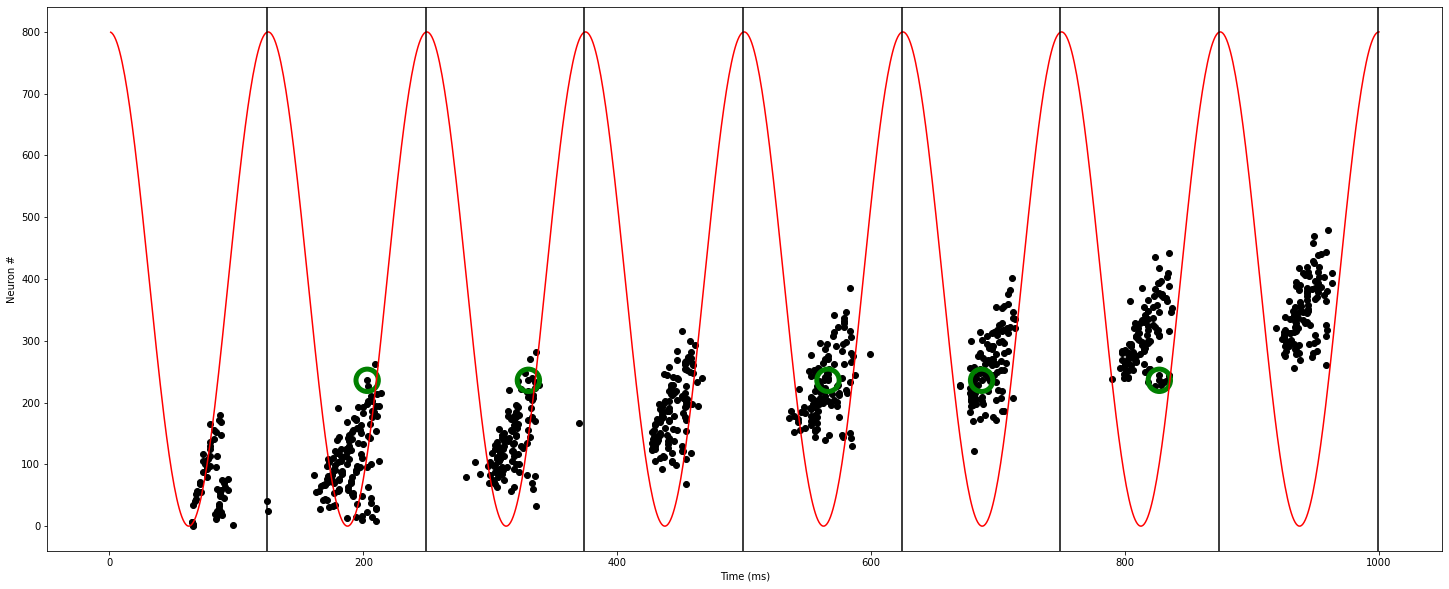

In [8]:
plt.figure(figsize=(25,10))
plt.plot(time*1000, np.interp(I_ext_in, (I_ext_in.min(), I_ext_in.max()), (0, Ne)),color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
plt.scatter(np.where(t_spikep==1)[1], np.where(t_spikep==1)[0],color='black')

# an example neuron 
ex_neuron=maxsp[6]  
t_spikep=t_spikep[ex_neuron,:]
y=ones(size(np.where(t_spikep==1)[0]))*ex_neuron
plt.scatter(np.where(t_spikep==1)[0],y,s=500,color='green',facecolors='none',linewidths=5)

xc=np.where(I_ext_in==I_ext_in.max())[0]
for i in xc:
    plt.axvline(x=i,color='black')

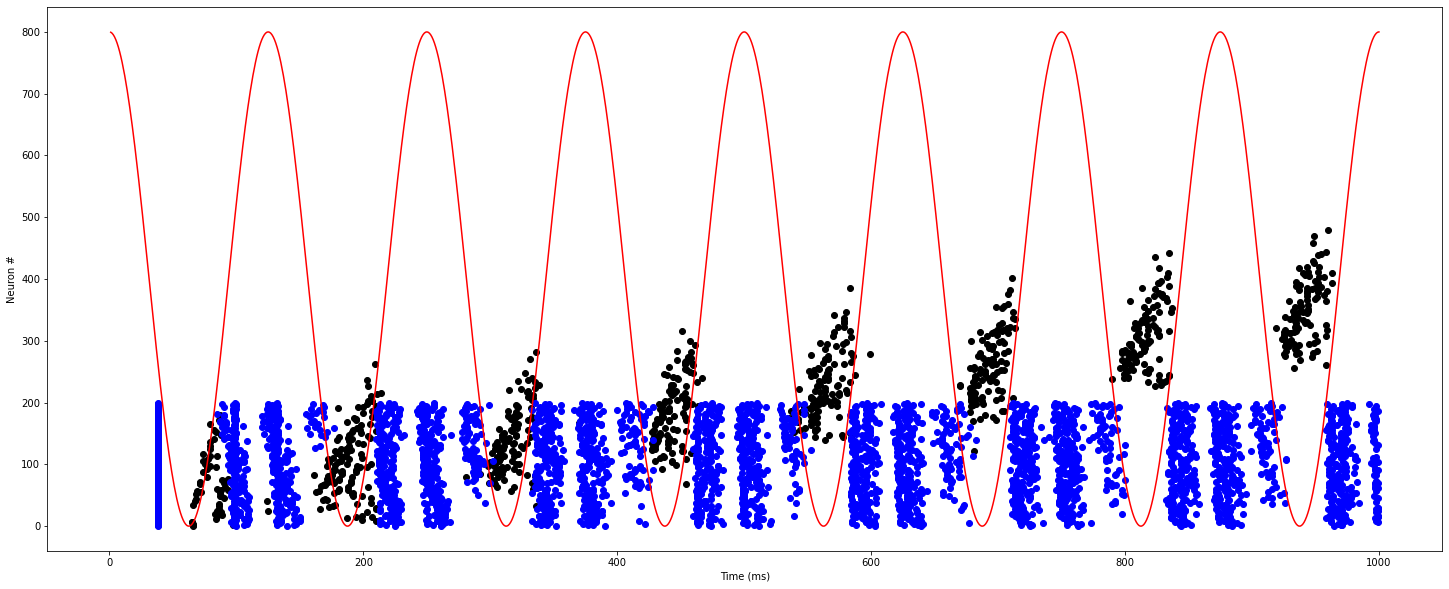

In [9]:
index=ones([1000],dtype=bool)
index[inhibitory_indx]=0
t_spikep=t_spike[index,:]
t_spikei=t_spike[inhibitory_indx,:]


plt.figure(figsize=(25,10))
plt.plot(time*1000, np.interp(I_ext_in, (I_ext_in.min(), I_ext_in.max()), (0, Ne)),color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
plt.scatter(np.where(t_spikep==1)[1], np.where(t_spikep==1)[0],color='black')

plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
plt.scatter(np.where(t_spikei==1)[1], np.where(t_spikei==1)[0],color='blue')

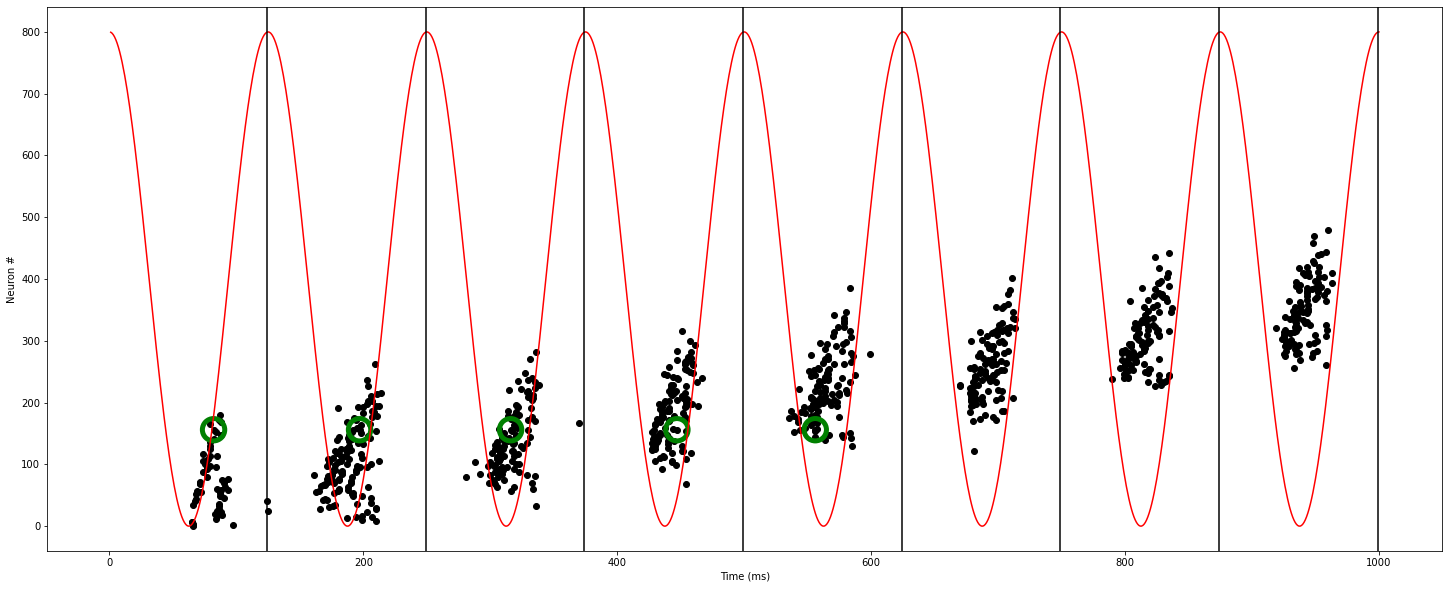

In [10]:
index=ones([1000],dtype=bool)
index[inhibitory_indx]=0
t_spikep=t_spike[index,:]
t_spikei=t_spike[inhibitory_indx,:]
maxsp=np.sum(t_spikep,axis=1)
maxsp=np.where(maxsp==max(maxsp))[0]


plt.figure(figsize=(25,10))
plt.plot(time*1000, np.interp(I_ext_in, (I_ext_in.min(), I_ext_in.max()), (0, Ne)),color='red')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
plt.scatter(np.where(t_spikep==1)[1], np.where(t_spikep==1)[0],color='black')

# an example neuron
ex_neuron=maxsp[0]  
t_spikep=t_spikep[ex_neuron,:]
y=ones(size(np.where(t_spikep==1)[0]))*ex_neuron
plt.scatter(np.where(t_spikep==1)[0],y,s=500,color='green',facecolors='none',linewidths=5) 

xc=np.where(I_ext_in==I_ext_in.max())[0]
for i in xc:
    plt.axvline(x=i,color='black')